In [2]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
import imageio

In [3]:
print("OpenCV Version:\t",cv2.__version__)

OpenCV Version:	 3.4.3


In [28]:
def display_imgs(img_list, labels=[],cols=5, fig_size=(30,30)):
    cmap = None
    rows = len(img_list) / cols
    plt.figure(figsize=fig_size)
    plt.subplots_adjust(left=0.0,right=0.5,wspace=0.0,hspace=0.2)
    for i in range(len(img_list)):
        plt.subplot(rows, cols, i+1)
        if len(img_list[i].shape) == 2:
            cmap = 'gray'
        if len(labels) > 0:
            plt.title(labels[i])
        plt.imshow(img_list[i], cmap=cmap)
    #plt.tight_layout()
    plt.show()

In [29]:
single_ex = False
img_loc = ''
img_loc2 = ''
img_loc3 = ''
imgs = []
if(single_ex):
    img_loc = 'Vehicle_Detection/images/lanes_1.jpg' # Good example
    img_loc2 = 'Vehicle_Detection/images/input.jpg' # Curve Example 
    img_loc3 = 'datasets/vehicle/Sunny_LISA_3/Sunny_imgs/20191110215_1.png' # Non-working example
else:
    loc = 'datasets/udacity_challenge_video/challenge_frames/'
    for f in os.listdir(loc):
        img = cv2.imread(loc + f)
        imgs.append(img)

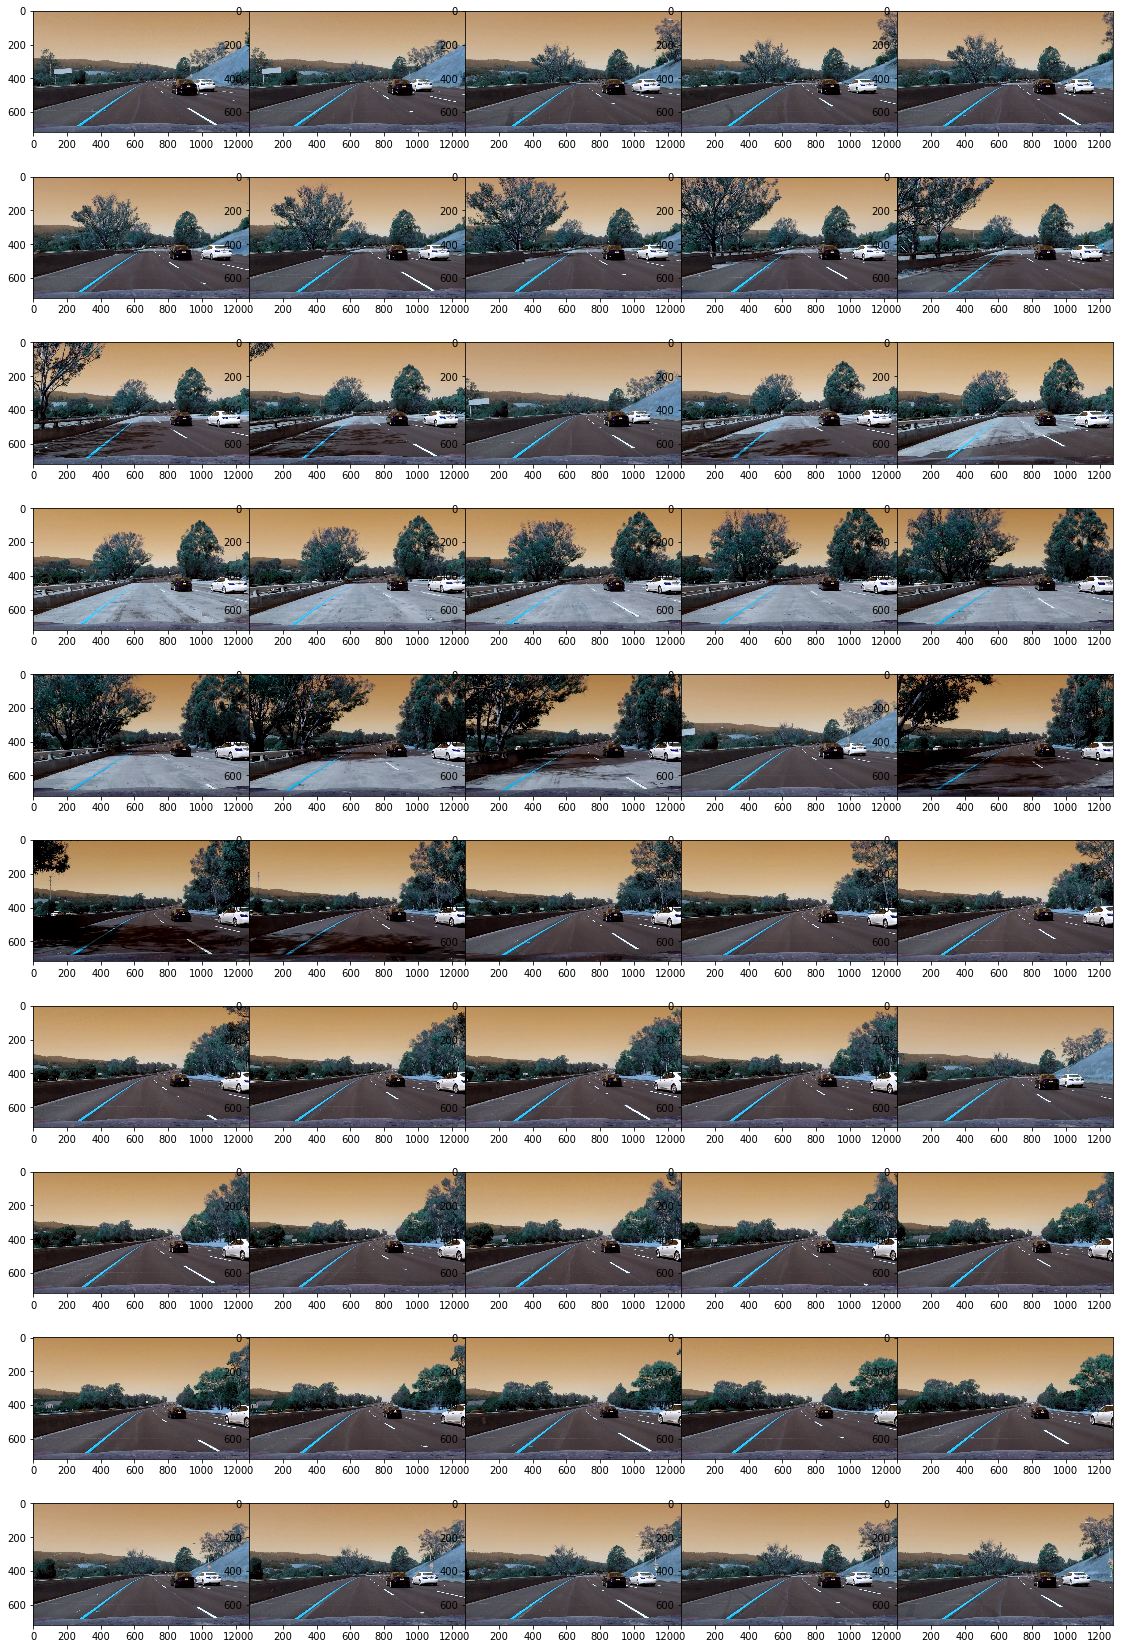

In [30]:
if(single_ex):
    img = cv2.imread(img_loc)
    plt.imshow(img)
else:
    display_imgs(imgs)

In [31]:
hls_im = None
hls_imgs = []
if(single_ex):
    hls_im = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    plt.imshow(hls_im)
else:
    for im in imgs:
        hls_im = cv2.cvtColor(im,cv2.COLOR_BGR2HLS)
        hls_imgs.append(hls_im)

In [32]:
w_lower_b = np.array([0, 200, 0], dtype=np.uint8)
w_upper_b = np.array([200, 255, 255], dtype=np.uint8)
y_lower_b = np.array([10, 0, 100], dtype=np.uint8)
y_upper_b = np.array([40, 255, 255], dtype=np.uint8)

In [33]:
# Yellow Lanes
yellow_mask = None
yellow_masks = []
if(single_ex):
    yellow_mask = cv2.inRange(hls_im,y_lower_b,y_upper_b)
    plt.imshow(yellow_mask)
else:
    for im in hls_imgs:
        yellow_mask = cv2.inRange(im,y_lower_b,y_upper_b) 
        yellow_masks.append(yellow_mask)

In [34]:
# White Lanes
white_mask = None
white_masks = []
if(single_ex):
    white_mask = cv2.inRange(hls_im,w_lower_b,w_upper_b)
    plt.imshow(white_mask)
else:
    for im in hls_imgs:
        white_mask = cv2.inRange(hls_im,w_lower_b,w_upper_b)
        white_masks.append(white_mask)


In [35]:
# Both types of lanes
combined_mask = None
combined_masks = []
if(single_ex):
    combined_mask = cv2.bitwise_or(yellow_mask,white_mask)
    plt.imshow(combined_mask)
else:
    for y_mask,w_mask in zip(yellow_masks,white_masks):
        combined_mask = cv2.bitwise_or(y_mask,w_mask)
        combined_masks.append(combined_mask)

In [36]:
# Blur Masked Image
blurred_mask = None
blurred_masks = []
if(single_ex):
    blurred_mask = cv2.GaussianBlur(combined_mask,(7,7),0)
    plt.imshow(blurred_mask)
else:
    for im in combined_masks:
        blurred_mask = cv2.GaussianBlur(im,(7,7),0)
        blurred_masks.append(blurred_mask)

In [37]:
edges = None
edges_ims = []
if(single_ex):
    edges = cv2.Canny(blurred_mask,100,190)
    plt.figure(figsize = (50,10))
    plt.imshow(edges,interpolation='nearest')
else:
    for im in blurred_masks:
        edges = cv2.Canny(im,100,190)
        edges_ims.append(edges)

In [38]:
def get_lanes(roi_im):
    lines = cv2.HoughLinesP(roi_im,rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)
    return lines

def draw_lines(image,lines):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image,(x1,y1),(x2,y2),color=[255, 0, 0],thickness=2)
    return image

# if(single_ex):
#     lines = get_lanes(edges)
#     image = draw_lines(edges,lines)
#     plt.figure(figsize = (50,10))
#     plt.imshow(image)
# else:
#     last = None
#     for im,edges in zip(imgs,edges_ims):
#         lines = get_lanes(edges)
#         image = draw_lines(im,lines)
#         last = image
#     plt.figure(figsize = (50,10))
#     plt.imshow(last)

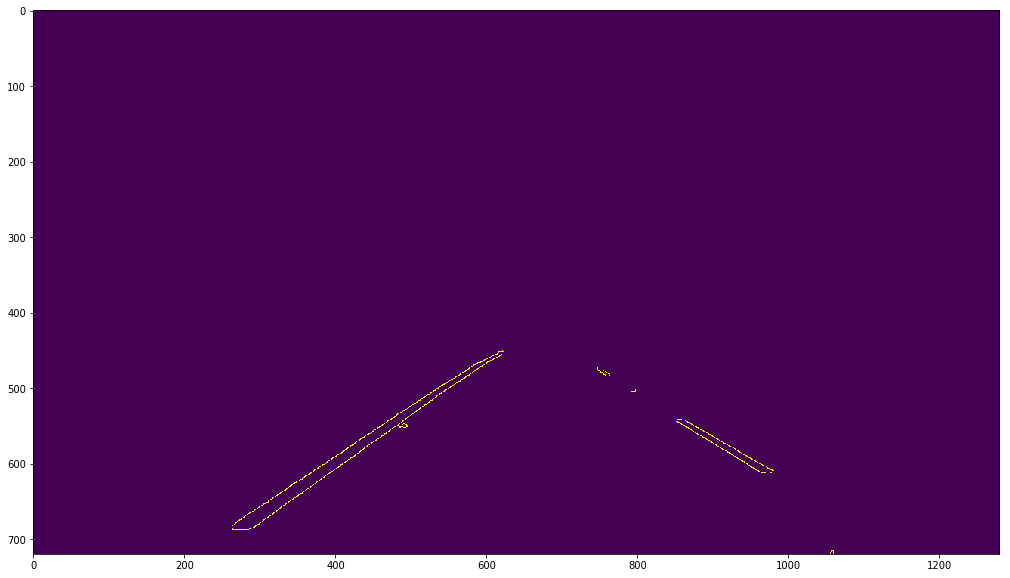

In [39]:
plt.close()
# Get ROI
def get_roi(img):
    rows, cols = img.shape[:2]
    #print('img rows={} --- img cols={}'.format(rows,cols))
    mask = np.zeros_like(img)
    
    #print(mask)
    
    left_bottom = np.array([int(cols * 0), int(rows)])
    right_bottom = np.array([int(cols * 1), int(rows)])
    left_top = np.array([int(cols * 0.50),int(rows * 0.59)])
    right_top = np.array([int(cols * 0.50), int(rows * 0.59)])
    
#     print(left_bottom)
#     print(right_bottom)
#     print(left_top)
#     print(right_top)
    w = right_top[0] - left_top[0]
    h = left_bottom[1] - left_top[1]
    #print("w = ",w)
    #print("h = ",h)
    #cv2.line(img,tuple(left_bottom),tuple(right_top),color=[255, 0, 0],thickness=2)
    #cv2.line(img,tuple(left_top),tuple(right_bottom),color=[255, 0, 0],thickness=2)
    #cv2.rectangle(img,tuple(left_top),(left_top[0]+w,left_top[1]+h),color=[255, 0, 0],thickness=2)
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)


roi_im = None
roi_imgs = []

if(single_ex):
    roi_im = get_roi(edges)
    plt.figure(figsize = (50,10))
    plt.imshow(roi_im)
else:
    last = None
    for im in edges_ims:
        roi = get_roi(im)
        roi_imgs.append(roi)
        last = roi
    plt.figure(figsize = (50,10))
    plt.imshow(last)

In [40]:
def get_highest_pts(lines):
    pt1 = lines[0][0][:2]
    pt2 = lines[0][0][-2:]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1<650 and y1 < pt1[1]):
                pt1 = [x1,y1]
            if(x2<650 and y2 < pt1[1]):
                pt1 = [x2,y2]
            if(x1>650 and y1 < pt2[1]):
                pt2 = [x1,y1]
            if(x2>650 and y2 < pt2[1]):
                pt2 = [x2,y2]
#             if(y1 < pt1[1]):
#                 pt1 = [x1,y1]
#             if(y2 < pt2[1]):
#                 pt2 = [x2,y2]
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.expand_dims(np.concatenate((pt1,pt2)).reshape((1,-1)),axis=1)


def get_highest_pts2(lines):
    lines = np.array(lines)
    pt1 = np.squeeze(lines[:,:,:2])
    pt2 = np.squeeze(lines[:,:,-2:])
    pts = np.concatenate((pt1,pt2))
    pts = pts[pts[:,0].argsort()]
    l_highest_pt = [pts[0][0],pts[0][1]]
    r_highest_pt = [pts[1][0],pts[1][1]]
    #print(l_highest_pt)
    #print(r_highest_pt)
    for pt in pts:
        x = pt[0]
        y = pt[1]
        if(x < 650 and y < l_highest_pt[1]):
            l_highest_pt = [x,y]
        if(x > 650 and y < r_highest_pt[1]):
            r_highest_pt = [x,y]
    pt1 = np.array(l_highest_pt)
    pt2 = np.array(r_highest_pt)
    return np.expand_dims(np.concatenate((pt1,pt2)).reshape((1,-1)),axis=1)

def get_lowest_pts(lines):
    lines = np.array(lines)
    pt1 = np.squeeze(lines[:,:,:2])
    pt2 = np.squeeze(lines[:,:,-2:])
    pts = np.concatenate((pt1,pt2))
    pts = pts[pts[:,0].argsort()]
    l_highest_pt = [pts[0][0],0]
    r_highest_pt = [pts[1][0],0]
#     print(l_highest_pt)
#     print(r_highest_pt)
    for pt in pts:
        x = pt[0]
        y = pt[1]
#         print("x = ", x)
#         print("y = ", y)
        if(x < 650 and y > l_highest_pt[1]):
            l_highest_pt = [x,y]
        if(x > 650 and y > r_highest_pt[1]):
            r_highest_pt = [x,y]
    pt1 = np.array(l_highest_pt)
    pt2 = np.array(r_highest_pt)
    print(l_highest_pt)
    print(r_highest_pt)
    return np.expand_dims(np.concatenate((pt1,pt2)).reshape((1,-1)),axis=1)


#get_highest_pts2(lines)

[260, 687]
[1073, 677]
[281, 687]
[963, 612]
[293, 686]
[964, 612]
[301, 684]
[965, 612]
[274, 687]
[1070, 677]
[283, 687]
[1021, 634]
[281, 687]
[1081, 676]
[293, 687]
[964, 612]
[302, 687]
[963, 612]
[302, 685]
[1099, 675]
[333, 684]
[964, 612]
[318, 685]
[1097, 673]
[296, 687]
[985, 624]
[305, 687]
[964, 612]
[291, 685]
[995, 614]
[285, 685]
[963, 612]
[265, 690]
[1071, 658]
[244, 687]
[1020, 645]
[229, 687]
[963, 612]
[249, 687]
[964, 612]
[233, 687]
[1063, 678]
[222, 689]
[964, 612]
[224, 687]
[1075, 678]
[299, 685]
[963, 612]
[236, 689]
[965, 612]
[227, 684]
[1039, 661]
[212, 688]
[964, 612]
[222, 688]
[1006, 648]
[273, 685]
[964, 612]
[258, 685]
[963, 612]
[283, 685]
[1072, 676]
[271, 685]
[963, 612]
[285, 685]
[1078, 676]
[289, 684]
[1003, 620]
[281, 687]
[963, 612]
[290, 685]
[1056, 659]
[312, 685]
[963, 612]
[299, 685]
[964, 612]
[330, 684]
[1093, 675]
[312, 685]
[963, 612]
[311, 685]
[1092, 674]
[324, 685]
[1046, 647]
[295, 683]
[1086, 675]
[322, 685]
[964, 612]
[296, 685]
[

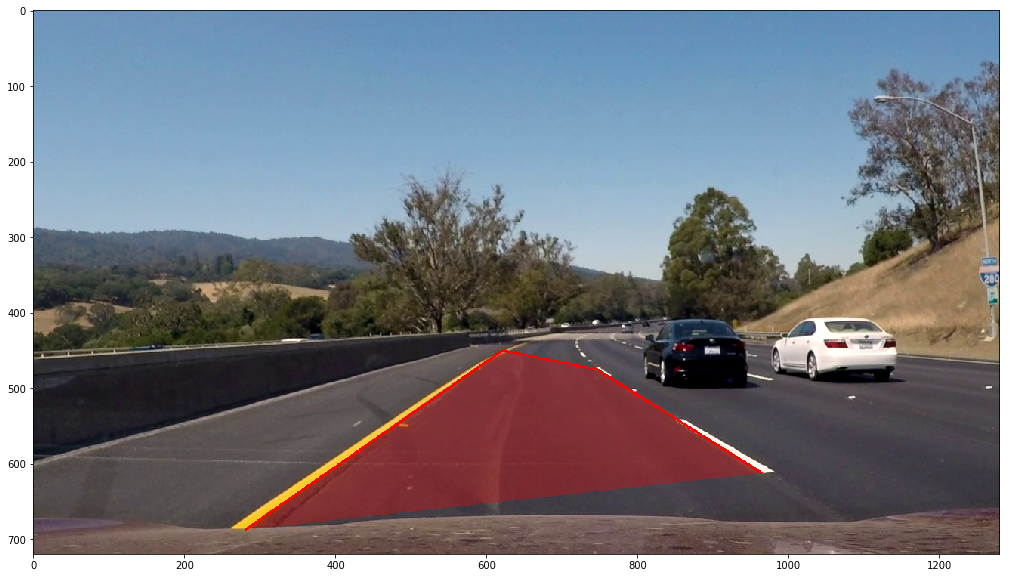

In [41]:
rgb_im = None
lines = None
predicted_lanes = []

if(single_ex):
    # Convert Img to RGB
    rgb_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Get the Hough Lines
    lines = get_lanes(roi_im)
    
    # Get the highest and lowest points
    connect_lane_line = get_highest_pts(lines)
    lowest_pts = get_lowest_pts(lines)
    arr_top = np.squeeze(connect_lane_line)
    arr_low = np.squeeze(lowest_pts)
    cv2.line(rgb_im,(arr_low[0],arr_low[1]),(arr_top[0],arr_top[1]),color=[255, 0, 0],thickness=2)
    cv2.line(rgb_im,(arr_low[2],arr_low[3]),(arr_top[2],arr_top[3]),color=[255, 0, 0],thickness=2)
    rgb_im = draw_lines(rgb_im,connect_lane_line)
    overlay = np.zeros_like(rgb_im)
    np.copyto(overlay,rgb_im)
    lane_area = np.array([[[arr_low[0],arr_low[1]],
                          [arr_low[2],arr_low[3]],
                          [arr_top[2],arr_top[3]],
                          [arr_top[0],arr_top[1]]
                         ]],dtype=np.int32)
    
    # Cover lane area location
    cv2.fillPoly(overlay,lane_area,color=255)
    alpha = 0.3
    cv2.addWeighted(overlay,alpha,rgb_im,1-alpha,0,rgb_im)
    plt.figure(figsize = (50,10))
    plt.imshow(rgb_im)
else:
    last = None
    for bgr_im,roi_edges in zip(imgs,roi_imgs):
        rgb_im = cv2.cvtColor(bgr_im,cv2.COLOR_BGR2RGB)
        lines = get_lanes(roi_edges)
        connect_lane_line = get_highest_pts2(lines)
        lowest_pts = get_lowest_pts(lines)
        arr_top = np.squeeze(connect_lane_line)
        arr_low = np.squeeze(lowest_pts)
        cv2.line(rgb_im,(arr_low[0],arr_low[1]),(arr_top[0],arr_top[1]),color=[255, 0, 0],thickness=2)
        cv2.line(rgb_im,(arr_low[2],arr_low[3]),(arr_top[2],arr_top[3]),color=[255, 0, 0],thickness=2)
        pred = draw_lines(rgb_im,connect_lane_line)
        overlay = np.zeros_like(rgb_im)
        np.copyto(overlay,rgb_im)
        lane_area = np.array([[[arr_low[0],arr_low[1]],
                              [arr_low[2],arr_low[3]],
                              [arr_top[2],arr_top[3]],
                              [arr_top[0],arr_top[1]]
                             ]],dtype=np.int32)
        # Cover lane area location
        cv2.fillPoly(overlay,lane_area,color=255)
        alpha = 0.3
        cv2.addWeighted(overlay,alpha,rgb_im,1-alpha,0,rgb_im)
        last = pred
        predicted_lanes.append(pred)
    plt.figure(figsize = (50,10))
    plt.imshow(last)

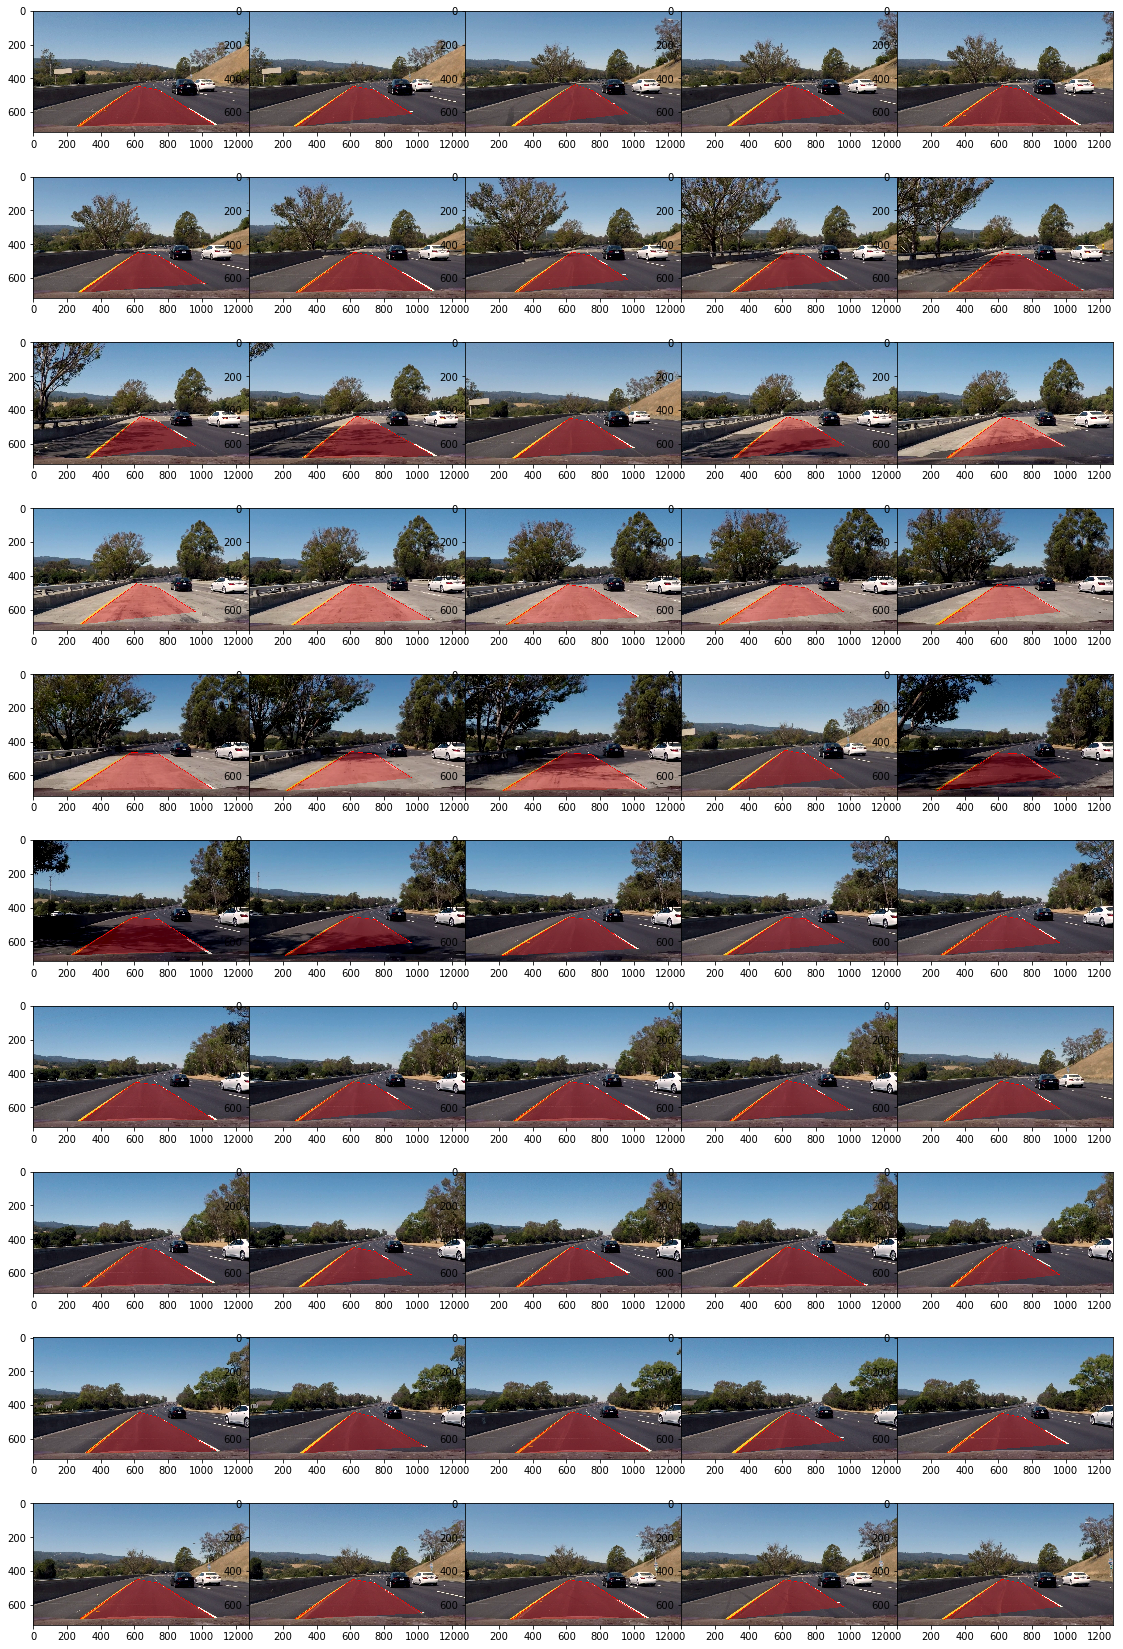

In [42]:
display_imgs(predicted_lanes)

In [43]:
save = False
if(save):
    imageio.mimsave('outputs/detected_lanes_py_4.gif', predicted_lanes)

In [ ]:
# Extrapolate Hough Transform Lines